<a href="https://www.kaggle.com/code/dataranch/spotify-artist-stats-eda-model-comparison?scriptVersionId=107373357" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Spotify Artist Stats Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

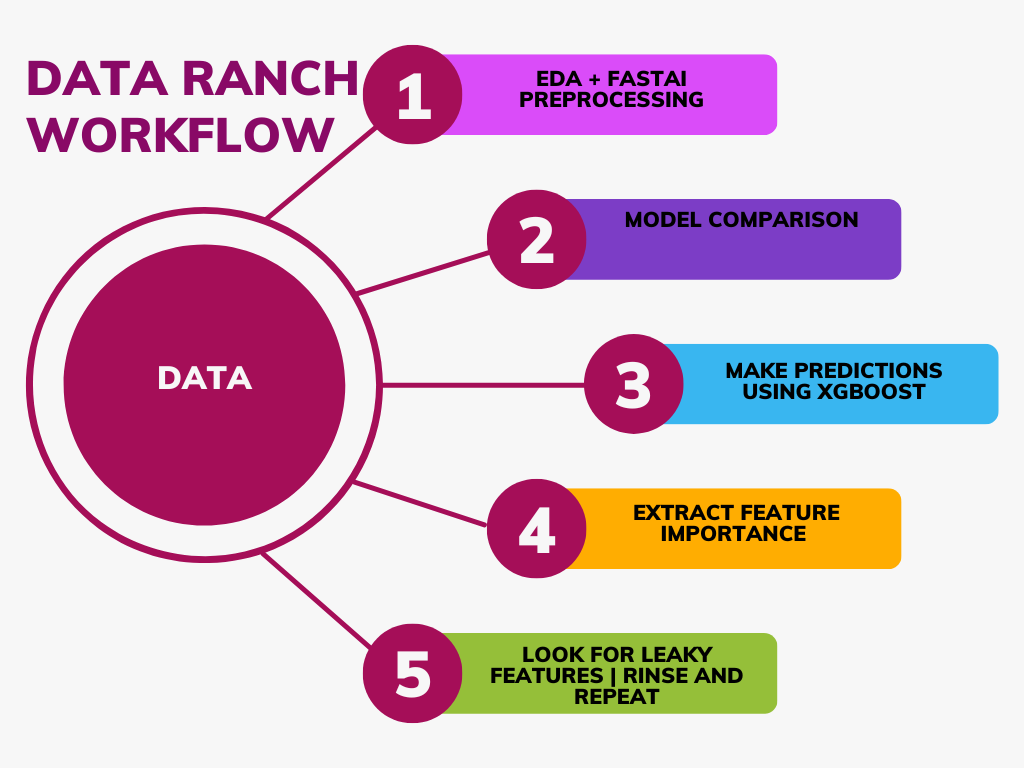

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.1 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'spotify-artist-stats'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/spotify-artist-stats
CSV!


In [12]:
df

,Unnamed: 0,Artist Name,Lead Streams,Feats,Tracks,One Billion,100 Million,Last Updated
0,1,Drake,"50,162,292,808","19,246,513,666",262,6,130,19.09.22
1,2,Bad Bunny,"44,369,032,140","5,391,990,975",163,5,118,20.09.22
2,3,Ed Sheeran,"38,153,682,361","2,791,278,201",240,10,62,19.09.22
3,4,The Weeknd,"34,767,779,741","4,288,903,657",186,8,72,19.09.22
4,5,Taylor Swift,"32,596,728,109","424,053,296",323,1,96,20.09.22
...,...,...,...,...,...,...,...,...
1004,1005,Gotye,"1,424,591,618","10,576,378",46,1,1,31.07.22
1005,1006,NIKI,"1,422,920,850","231,405,433",55,0,4,14.09.22
1006,1007,Duke Dumont,"1,422,096,182","24,622,115",121,0,2,31.07.22
1007,1008,Laura Pausini,"1,421,622,604","293,291,443",434,0,0,13.09.22


In [13]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
#remove features we don't want to make predictions on

#We created new columns out of these columns, drop them as they're useless
# ================================
del(df['Tracks'])
del(df['Feats'])
del(df['Lead Streams'])
# ================================

del(df['Artist Name_processed'])

del(df['Unnamed: 0'])
del(df['One Billion'])
del(df['100 Million'])
del(df['Last Updated'])
del(df['Artist Name'])

In [15]:
df

,Lead Streams_processed,Feats_processed,Tracks_processed
0,50162292808.00,19246513666.00,262.00
1,44369032140.00,5391990975.00,163.00
2,38153682361.00,2791278201.00,240.00
3,34767779741.00,4288903657.00,186.00
4,32596728109.00,424053296.00,323.00
...,...,...,...
1004,1424591618.00,10576378.00,46.00
1005,1422920850.00,231405433.00,55.00
1006,1422096182.00,24622115.00,121.00
1007,1421622604.00,293291443.00,434.00


In [16]:
df.isna().sum()

Lead Streams_processed    9
Feats_processed           9
Tracks_processed          9
dtype: int64

In [17]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

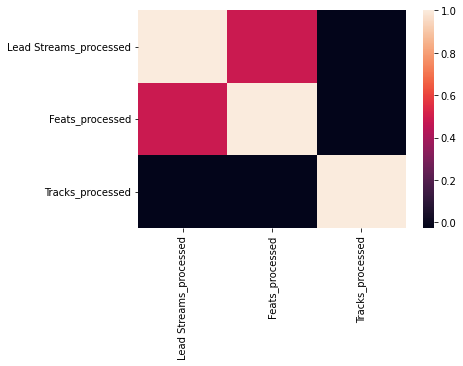

In [18]:
sns.heatmap(df.corr())

In [19]:
df.head().style.background_gradient(cmap = "inferno")

,Lead Streams_processed,Feats_processed,Tracks_processed
0,50162292808.00,19246513666.00,262.00
1,44369032140.00,5391990975.00,163.00
2,38153682361.00,2791278201.00,240.00
3,34767779741.00,4288903657.00,186.00
4,32596728109.00,424053296.00,323.00


In [20]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
Lead Streams_processed,1000.00,4291402641.14,4827223540.65,1420597420.00,1850498924.25,2613282547.00,4625016438.00,50162292808.00
Feats_processed,1000.00,861908543.15,1742020445.38,0.00,13723015.75,183307792.00,797751478.25,19246513666.00
Tracks_processed,1000.00,267.90,620.64,11.00,86.75,147.50,252.25,11475.00


In [21]:
df.columns

Index(['Lead Streams_processed', 'Feats_processed', 'Tracks_processed'], dtype='object')

Target Variable: Tracks_processed
CATS=====================
[]
CONTS=====================
['Lead Streams_processed', 'Feats_processed']
2
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Lead Streams_processed', 'Feats_processed']
Categorical variables that made the cut : []
Tabular Object size: 1001


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -3.079915746039899, 'Adjusted R-Squared': -3.1213362104667004, 'RMSE': 644.4698637324174, 'Time taken': 0.08781814575195312}


  5%|▍         | 2/42 [00:00<00:02, 15.53it/s]

{'Model': 'BaggingRegressor', 'R-Squared': -1.4150278235262963, 'Adjusted R-Squared': -1.4395458724961063, 'RMSE': 495.83603494502086, 'Time taken': 0.04044795036315918}
{'Model': 'BayesianRidge', 'R-Squared': -0.009659720118133208, 'Adjusted R-Squared': -0.019910072606642126, 'RMSE': 320.60074852569477, 'Time taken': 0.03204751014709473}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.173082108506327, 'Adjusted R-Squared': -1.1951438558008074, 'RMSE': 470.3434330359041, 'Time taken': 0.012426137924194336}
{'Model': 'DummyRegressor', 'R-Squared': -0.009659746589040452, 'Adjusted R-Squared': -0.019910099346289734, 'RMSE': 320.60077, 'Time taken': 0.008694887161254883}
{'Model': 'ElasticNet', 'R-Squared': -0.012127938959936468, 'Adjusted R-Squared': -0.022403349507753134, 'RMSE': 320.99237, 'Time taken': 0.01343846321105957}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check tha

 21%|██▏       | 9/42 [00:00<00:01, 23.03it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -1.9189551768045456, 'Adjusted R-Squared': -1.9485892395132214, 'RMSE': 545.1182596593146, 'Time taken': 0.1842041015625}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2248450.937335459, 'Adjusted R-Squared': -2271277.860557139, 'RMSE': 478430.45898889913, 'Time taken': 0.12286710739135742}


 29%|██▊       | 12/42 [00:00<00:01, 15.68it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.1397027061879934, 'Adjusted R-Squared': -0.15127329203761763, 'RMSE': 340.6220876822426, 'Time taken': 0.1792585849761963}


 43%|████▎     | 18/42 [00:01<00:01, 13.90it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.30311894646228055, 'Adjusted R-Squared': -0.3163485804365169, 'RMSE': 364.22440814893184, 'Time taken': 0.35599231719970703}
{'Model': 'HuberRegressor', 'R-Squared': -0.0696322145696402, 'Adjusted R-Squared': -0.08049142486983962, 'RMSE': 329.98504182321307, 'Time taken': 0.016321420669555664}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.6266140297531568, 'Adjusted R-Squared': -0.6431278777709555, 'RMSE': 406.9296, 'Time taken': 0.010272741317749023}
{'Model': 'KernelRidge', 'R-Squared': -0.5804402354338842, 'Adjusted R-Squared': -0.5964853139662081, 'RMSE': 401.11237, 'Time taken': 0.06235003471374512}
{'Model': 'Lars', 'R-Squared': -0.015114552133951742, 'Adjusted R-Squared': -0.02542028362769755, 'RMSE': 321.4656, 'Time taken': 0.021694660186767578}
{'Model': 'LarsCV', 'R-Squared': -0.009659746589040452, 'Adjusted R-Squared': -0.019910099346289734, 'RMSE': 320.60077, 'Time taken': 0.06635117530822754}
{'Model': 'Lasso', 

 67%|██████▋   | 28/42 [00:02<00:01,  8.53it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.22958613589585175, 'Adjusted R-Squared': -0.2420692438744898, 'RMSE': 353.79892, 'Time taken': 1.312058925628662}
{'Model': 'NuSVR', 'R-Squared': -0.05094788171657494, 'Adjusted R-Squared': -0.06161740335836763, 'RMSE': 327.0902556575172, 'Time taken': 0.09631037712097168}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.017475015077291767, 'Adjusted R-Squared': -0.027804710661832877, 'RMSE': 321.8391654872272, 'Time taken': 0.020142555236816406}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.017475015077291767, 'Adjusted R-Squared': -0.027804710661832877, 'RMSE': 321.8391654872272, 'Time taken': 0.014314889907836914}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.08408813657889525, 'Adjusted R-Squared': -0.09509410750863023, 'RMSE': 332.2074079307793, 'Time taken': 0.011224746704101562}
{'Model': 'PoissonRegressor', 'R-Squared': -0.01623527234445543, 'Adjusted R-Squared': -0.026552381708358608, 'RMSE': 321.643033211506

 79%|███████▊  | 33/42 [00:19<00:11,  1.29s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.08966367652666274, 'Adjusted R-Squared': -0.10072625192287266, 'RMSE': 333.06059512660937, 'Time taken': 17.010132312774658}
{'Model': 'RANSACRegressor', 'R-Squared': -0.2041162237032177, 'Adjusted R-Squared': -0.21634075389309815, 'RMSE': 350.1154, 'Time taken': 0.10113000869750977}


 83%|████████▎ | 35/42 [00:20<00:07,  1.03s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.5084307997993505, 'Adjusted R-Squared': -0.523744818071425, 'RMSE': 391.8679206142039, 'Time taken': 0.2687253952026367}
{'Model': 'Ridge', 'R-Squared': -0.015101668396837464, 'Adjusted R-Squared': -0.025407269091221707, 'RMSE': 321.4636, 'Time taken': 0.01117563247680664}
{'Model': 'RidgeCV', 'R-Squared': -0.014987569151491797, 'Adjusted R-Squared': -0.025292011477902943, 'RMSE': 321.4455207324686, 'Time taken': 0.012193679809570312}
{'Model': 'SGDRegressor', 'R-Squared': -0.014544908307303261, 'Adjusted R-Squared': -0.024844856614991695, 'RMSE': 321.37541797088846, 'Time taken': 0.011039018630981445}
{'Model': 'SVR', 'R-Squared': -0.08490457275193797, 'Adjusted R-Squared': -0.09591883237378518, 'RMSE': 332.33247852659497, 'Time taken': 0.05353116989135742}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.015114553980942969, 'Adjusted R-Squared': -0.025420285493439776, 'RMSE': 321.4656, 'Time taken': 0.010783672332763672}
{'Mod

100%|██████████| 42/42 [00:20<00:00,  2.00it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.7711560470060015, 'Adjusted R-Squared': -0.7891373266710371, 'RMSE': 424.62488, 'Time taken': 0.5018072128295898}
{'Model': 'LGBMRegressor', 'R-Squared': -0.5414488858135318, 'Adjusted R-Squared': -0.5570981130806743, 'RMSE': 396.1335087778015, 'Time taken': 0.13864707946777344}
Project: spotify-artist-stats
spotify-artist-stats
Target: Tracks_processed
Tracks_processed
Target Standard Deviation: 674.447265625
                               Adjusted R-Squared   R-Squared      RMSE  \
Model                                                                     
BayesianRidge                               -0.02       -0.01    320.60   
LassoLarsIC                                 -0.02       -0.01    320.60   
DummyRegressor                              -0.02       -0.01    320.60   
LassoLarsCV                                 -0.02       -0.01    320.60   
LassoLars                                   -0.02       -0.01    320.60   
LarsCV             

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,579884.312500,137165.390625,370.358459,00:00
1,555689.687500,129718.031250,360.163910,00:00
2,526844.125000,2770691.500000,1664.539429,00:00


Better model found at epoch 0 with _rmse value: 370.35845947265625.
Better model found at epoch 1 with _rmse value: 360.1639099121094.
No improvement since epoch 1: early stopping


,Lead Streams_processed,Feats_processed,Tracks_processed,Tracks_processed_pred
0,-0.59,-0.48,160.00,464.96
1,-0.08,-0.50,79.00,337.87
2,-0.58,-0.49,45.00,472.46
3,0.25,0.12,280.00,39.57
4,3.10,-0.47,126.00,209.76
5,-0.32,0.64,62.00,213.61
6,-0.53,-0.11,152.00,139.48
7,-0.58,-0.27,151.00,331.44
8,-0.58,0.72,156.00,417.88


<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  156.00     225.73
1  385.00     227.83
2  301.00      54.32
3  175.00     204.66
4   75.00     316.28
XGBoost RMSE:  424.62488


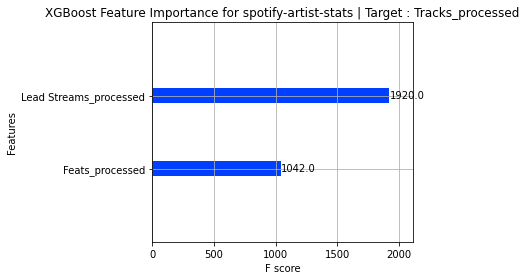

Target Variable: Feats_processed
CATS=====================
[]
CONTS=====================
['Lead Streams_processed', 'Tracks_processed']
2
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Lead Streams_processed', 'Tracks_processed']
Categorical variables that made the cut : []
Tabular Object size: 1001


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.17781146770625056, 'Adjusted R-Squared': 0.16946437600783681, 'RMSE': 1879843002.4034383, 'Time taken': 0.03137636184692383}
{'Model': 'BaggingRegressor', 'R-Squared': 0.16430807456559737, 'Adjusted R-Squared': 0.15582389258149176, 'RMSE': 1895217140.6527739, 'Time taken': 0.03752899169921875}
{'Model': 'BayesianRidge', 'R-Squared': -0.0009778931356037024, 'Adjusted R-Squared': -0.011140105248655496, 'RMSE': 2074187991.614884, 'Time taken': 0.009493112564086914}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.18208505167545774, 'Adjusted R-Squared': -0.19408591514424423, 'RMSE': 2254032819.7016263, 'Time taken': 0.010929107666015625}
{'Model': 'DummyRegressor', 'R-Squared': -0.0009778573005763125, 'Adjusted R-Squared': -0.011140069049820678, 'RMSE': 2074187900.0, 'Time taken': 0.008373498916625977}


 14%|█▍        | 6/42 [00:00<00:00, 54.71it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.274761109956714, 'Adjusted R-Squared': 0.2673982785857162, 'RMSE': 1765535400.0, 'Time taken': 0.01130223274230957}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (1,1) we computed 740.9570922851562 but the user-supplied value was 740.957275390625.
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.27062676692705145, 'Adjusted R-Squared': -0.2835265310582906, 'RMSE': 2336925526.9273868, 'Time taken': 0.010197877883911133}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.2001930103454692, 'Adjusted R-Squared': 0.1920731424301948, 'RMSE': 1854080004.190633, 'Time taken': 0.17455101013183594}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1937.7543549167767, 'Adjusted R-Squared': -1957

 29%|██▊       | 12/42 [00:00<00:01, 18.83it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.10025548635892612, 'Adjusted R-Squared': 0.09112102429150404, 'RMSE': 1966506907.0714781, 'Time taken': 0.16144299507141113}


 45%|████▌     | 19/42 [00:01<00:01, 15.81it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.13205852109155758, 'Adjusted R-Squared': 0.12324693247319773, 'RMSE': 1931439435.6160147, 'Time taken': 0.35692429542541504}
{'Model': 'HuberRegressor', 'R-Squared': -0.08780192609401039, 'Adjusted R-Squared': -0.09884560047059932, 'RMSE': 2162274289.14618, 'Time taken': 0.019283533096313477}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.29113269319609825, 'Adjusted R-Squared': 0.2839360707919977, 'RMSE': 1745494000.0, 'Time taken': 0.010335922241210938}
{'Model': 'KernelRidge', 'R-Squared': 0.16982615251844835, 'Adjusted R-Squared': 0.16139799163031077, 'RMSE': 1888949800.0, 'Time taken': 0.03034496307373047}
{'Model': 'Lars', 'R-Squared': 0.3598149190692699, 'Adjusted R-Squared': 0.35331557814611525, 'RMSE': 1658779400.0, 'Time taken': 0.031006574630737305}
{'Model': 'LarsCV', 'R-Squared': 0.3598149190692699, 'Adjusted R-Squared': 0.35331557814611525, 'RMSE': 1658779400.0, 'Time taken': 0.07250523567199707}
{'Model': 'Lasso'

 62%|██████▏   | 26/42 [00:01<00:00, 20.92it/s]

{'Model': 'LassoLars', 'R-Squared': 0.3598149179280472, 'Adjusted R-Squared': 0.3533155769933065, 'RMSE': 1658779400.0, 'Time taken': 0.01132345199584961}
{'Model': 'LassoLarsCV', 'R-Squared': 0.3598149190692699, 'Adjusted R-Squared': 0.35331557814611525, 'RMSE': 1658779400.0, 'Time taken': 0.016677141189575195}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3476258584301335, 'Adjusted R-Squared': 0.34100277069845975, 'RMSE': 1674496400.0, 'Time taken': 0.010468482971191406}
{'Model': 'LinearRegression', 'R-Squared': 0.3598149737877442, 'Adjusted R-Squared': 0.3533156334201071, 'RMSE': 1658779400.0, 'Time taken': 0.008893728256225586}
{'Model': 'LinearSVR', 'R-Squared': -0.19390893584380642, 'Adjusted R-Squared': -0.20602983874577396, 'RMSE': 2265277826.3625145, 'Time taken': 0.008900642395019531}
{'Model': 'MLPRegressor', 'R-Squared': -0.1939092247199672, 'Adjusted R-Squared': -0.20603013055468766, 'RMSE': 2265278000.0, 'Time taken': 0.15096545219421387}


 69%|██████▉   | 29/42 [00:01<00:00, 21.12it/s]

{'Model': 'NuSVR', 'R-Squared': -0.05853970465172731, 'Adjusted R-Squared': -0.06928630063803931, 'RMSE': 2132993091.6537166, 'Time taken': 0.10249781608581543}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.36137718449875755, 'Adjusted R-Squared': 0.3548937041383389, 'RMSE': 1656754228.2425675, 'Time taken': 0.017895936965942383}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.36137718449875755, 'Adjusted R-Squared': 0.3548937041383389, 'RMSE': 1656754228.2425675, 'Time taken': 0.01414942741394043}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.1936457526963027, 'Adjusted R-Squared': -0.2057639836881433, 'RMSE': 2265028135.7079716, 'Time taken': 0.047869205474853516}
{'Model': 'PoissonRegressor', 'R-Squared': 0.44707614253452077, 'Adjusted R-Squared': 0.4414627023572062, 'RMSE': 1541588767.2348418, 'Time taken': 0.01279759407043457}


 76%|███████▌  | 32/42 [00:04<00:03,  3.23it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.18882019945815953, 'Adjusted R-Squared': -0.20088944006179577, 'RMSE': 2260445082.9424553, 'Time taken': 3.2851250171661377}
{'Model': 'RANSACRegressor', 'R-Squared': -0.1811174482376281, 'Adjusted R-Squared': -0.19310848832125882, 'RMSE': 2253110000.0, 'Time taken': 0.0725710391998291}


 95%|█████████▌| 40/42 [00:05<00:00,  6.04it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.1777637312213498, 'Adjusted R-Squared': 0.16941615488857165, 'RMSE': 1879897573.7037382, 'Time taken': 0.28306150436401367}
{'Model': 'Ridge', 'R-Squared': 0.35956223189481074, 'Adjusted R-Squared': 0.3530603256196311, 'RMSE': 1659106800.0, 'Time taken': 0.012676477432250977}
{'Model': 'RidgeCV', 'R-Squared': 0.357294034028822, 'Adjusted R-Squared': 0.35076910036414, 'RMSE': 1662042168.256191, 'Time taken': 0.010853290557861328}
{'Model': 'SGDRegressor', 'R-Squared': 0.3529834830770582, 'Adjusted R-Squared': 0.3464147874737795, 'RMSE': 1667606411.7767193, 'Time taken': 0.010415315628051758}
{'Model': 'SVR', 'R-Squared': -0.12716516108491804, 'Adjusted R-Squared': -0.13860846221268375, 'RMSE': 2201048696.2830896, 'Time taken': 0.050919294357299805}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3598149737877442, 'Adjusted R-Squared': 0.3533156334201071, 'RMSE': 1658779400.0, 'Time taken': 0.010342121124267578}
{'Model': 'TweedieR

100%|██████████| 42/42 [00:05<00:00,  7.14it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.037534325879116315, 'Adjusted R-Squared': -0.0480676692890567, 'RMSE': 2111723600.0, 'Time taken': 0.4387505054473877}
{'Model': 'LGBMRegressor', 'R-Squared': 0.14631633575979763, 'Adjusted R-Squared': 0.13764949652893266, 'RMSE': 1915509711.1118107, 'Time taken': 0.15358567237854004}
Project: spotify-artist-stats
spotify-artist-stats
Target: Feats_processed
Feats_processed
Target Standard Deviation: 1646719360.0
                               Adjusted R-Squared  R-Squared           RMSE  \
Model                                                                         
PoissonRegressor                             0.44       0.45  1541588767.23   
OrthogonalMatchingPursuit                    0.35       0.36  1656754228.24   
OrthogonalMatchingPursuitCV                  0.35       0.36  1656754228.24   
TransformedTargetRegressor                   0.35       0.36  1658779392.00   
LinearRegression                             0.35       0.36  16587

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,3421673588569145344.000000,5131484538505003008.000000,2265277952.000000,00:00
1,3403596517896880128.000000,5131482889237561344.000000,2265277696.000000,00:00
2,3395010156717670400.000000,5131474093144539136.000000,2265275648.000000,00:00
3,3428500181388099584.000000,5131453202423611392.000000,2265271040.000000,00:00
4,3460250228907573248.000000,5131371838563155968.000000,2265253376.000000,00:00
5,3485831191561502720.000000,5131210210353872896.000000,2265217536.000000,00:00
6,3485821570834759680.000000,5131039236295753728.000000,2265179648.000000,00:00
7,3465341242622083072.000000,5130736320842301440.000000,2265112832.000000,00:00
8,3419575445505441792.000000,5130655506737659904.000000,2265095168.000000,00:00
9,3424311866719993856.000000,5131149737214345216.000000,2265204224.000000,00:00


Better model found at epoch 0 with _rmse value: 2265277952.0.
Better model found at epoch 1 with _rmse value: 2265277696.0.
Better model found at epoch 2 with _rmse value: 2265275648.0.
Better model found at epoch 3 with _rmse value: 2265271040.0.
Better model found at epoch 4 with _rmse value: 2265253376.0.
Better model found at epoch 5 with _rmse value: 2265217536.0.
Better model found at epoch 6 with _rmse value: 2265179648.0.
Better model found at epoch 7 with _rmse value: 2265112832.0.
Better model found at epoch 8 with _rmse value: 2265095168.0.
No improvement since epoch 8: early stopping


,Lead Streams_processed,Tracks_processed,Feats_processed,Feats_processed_pred
0,-0.27,-0.32,1117326336.00,57704.90
1,-0.57,1.89,312985184.00,58856.14
2,-0.48,-0.14,527168224.00,57948.30
3,0.26,-0.00,1108375040.00,85083.22
4,-0.59,-0.37,0.00,57847.80
5,-0.53,-0.24,58137112.00,57909.80
6,-0.39,-0.21,225114576.00,57839.97
7,-0.29,-0.32,138810384.00,57719.82
8,0.07,-0.18,378905.00,60770.73


<Figure size 432x288 with 0 Axes>

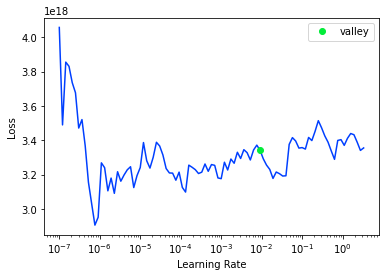

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
         actual    predicted
0   25567336.00 223051040.00
1      84795.00 182102480.00
2 1313168768.00 485514560.00
3  179247040.00 176556816.00
4     306912.00 514897216.00
XGBoost RMSE:  2111723600.0


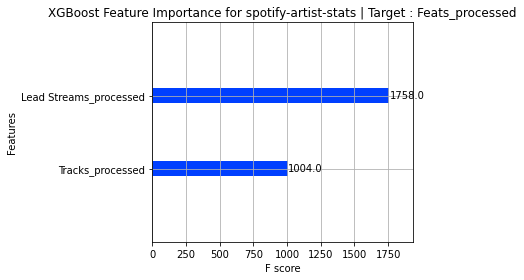

<Figure size 432x288 with 0 Axes>

In [22]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

                  feature  importance
0  Lead Streams_processed     1920.00
1         Feats_processed     1042.00
0  Lead Streams_processed     1758.00
1        Tracks_processed     1004.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

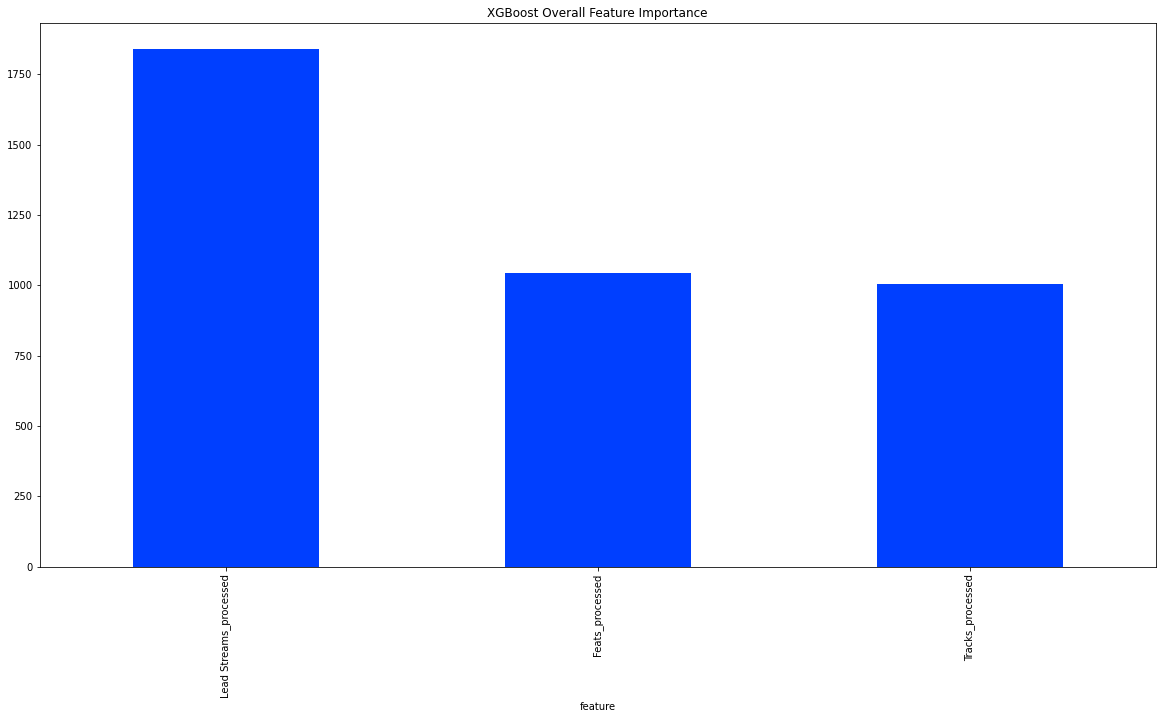

In [23]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [24]:
df.isna().sum()

Lead Streams_processed    0
Feats_processed           0
Tracks_processed          0
dtype: int64

# **To Be Continued...**